In [1]:
import os
import psycopg 
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [2]:
# подгружаем .env
load_dotenv()

True

In [3]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [4]:
TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "plots_creation" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

In [5]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,6023,5025-GOOKI,2018-06-01,NaT,Month-to-month,Yes,Credit card (automatic),18.9,347.65,None,None,None,None,None,None,None,Female,0,No,No,No,0
1,6024,4698-KVLLG,2015-11-01,NaT,Two year,No,Credit card (automatic),19.6,967.90,None,None,None,None,None,None,None,Female,1,No,No,No,0


In [6]:
### ЗАДАНИЕ 1

/tmp/ipykernel_21068/1456631547.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(df[x].unique(), rotation=45)


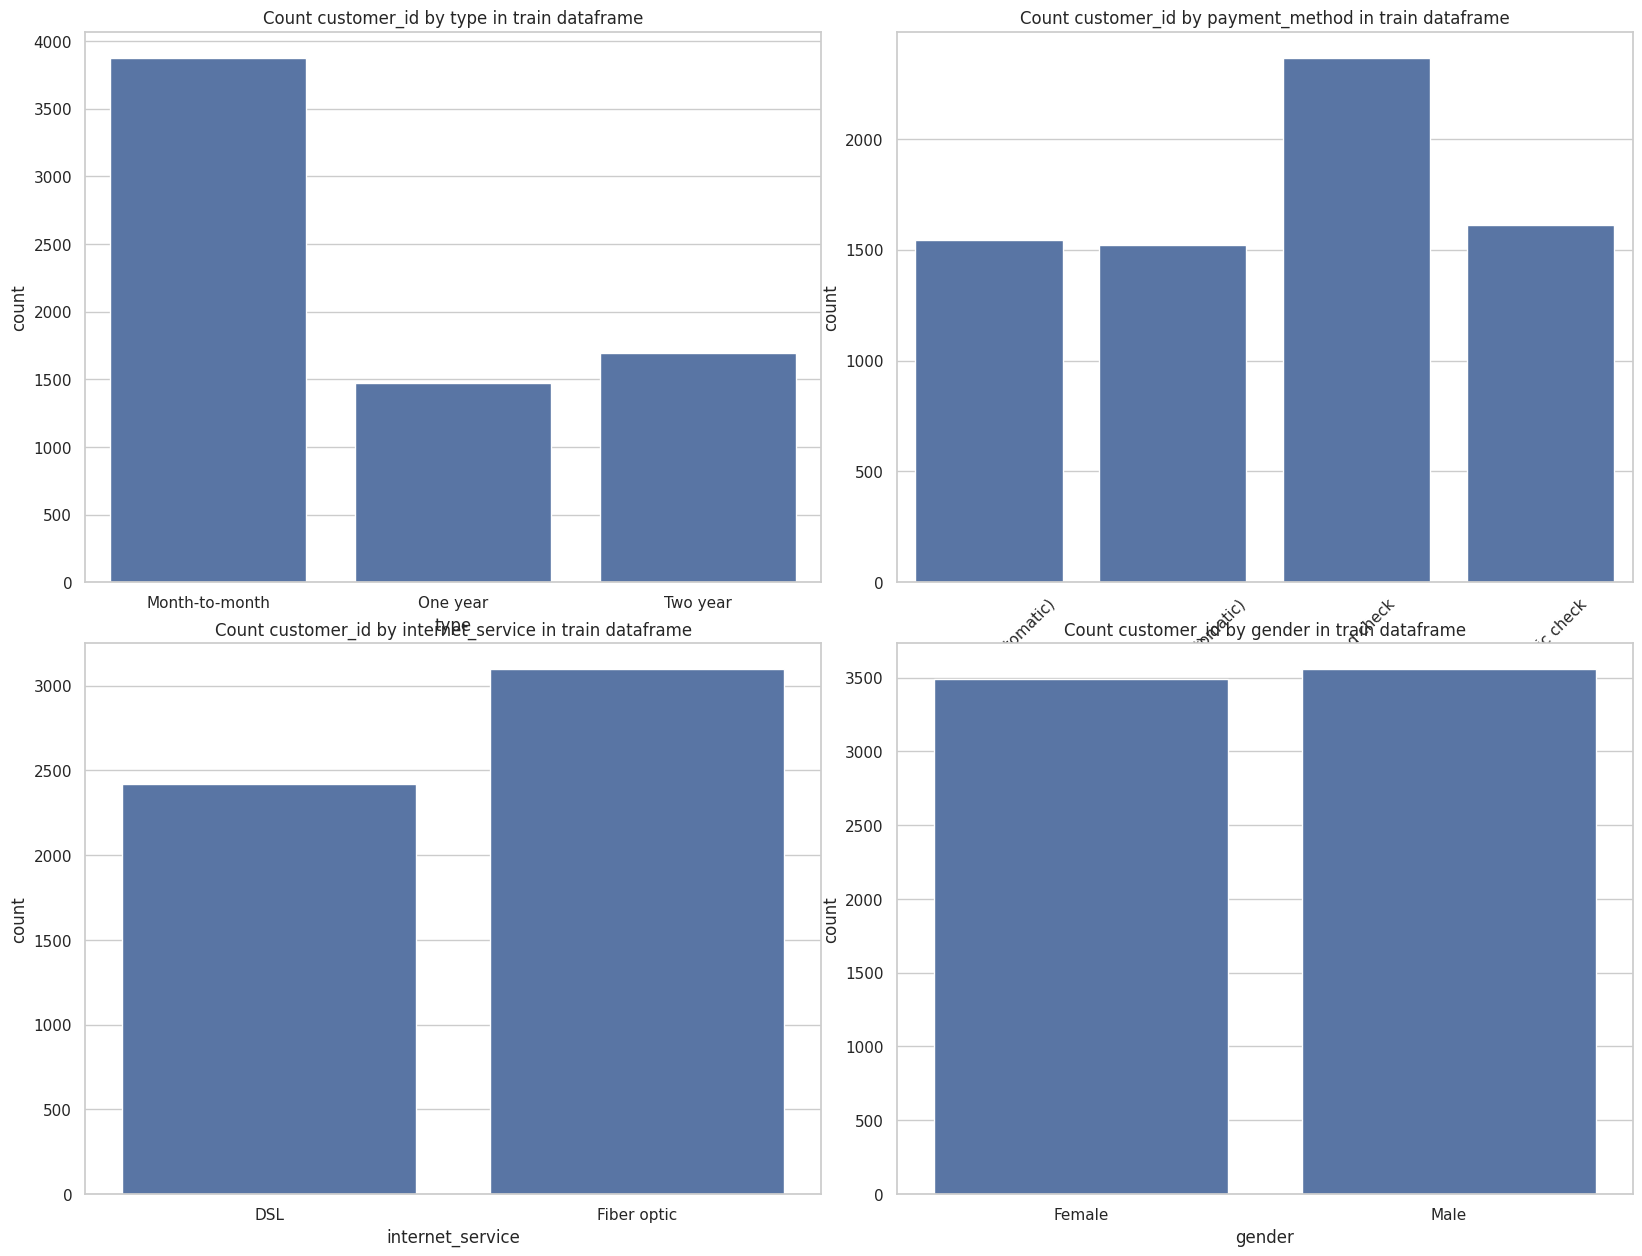

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Создаем фигуру и оси
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)
# График 1: Количество пользователей по type
x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

# График 2: Количество пользователей по payment_method
x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(df[x].unique(), rotation=45)

# График 3: Количество пользователей по internet_service
x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')

# График 4: Количество пользователей по gender
x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

# Сохраняем график в директорию ASSETS_DIR
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))
plt.show()

In [ ]:
### ЗАДАНИЕ 2

In [8]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]  # Статистика для агрегации

# Сортируем по убыванию и выводим первые 10 строк
print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv   
0                No            No                No           No           No  \
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

In [ ]:
### ЗАДАНИЕ 3

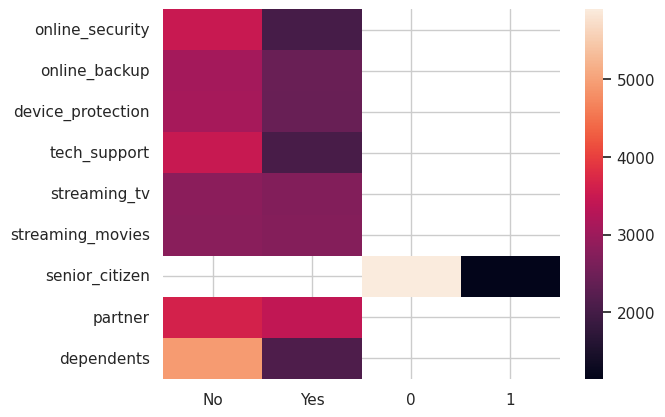

In [9]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)# ваш код здесь

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

In [ ]:
### ЗАДАНИЕ 4

/tmp/ipykernel_21068/349014436.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_21068/349014436.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


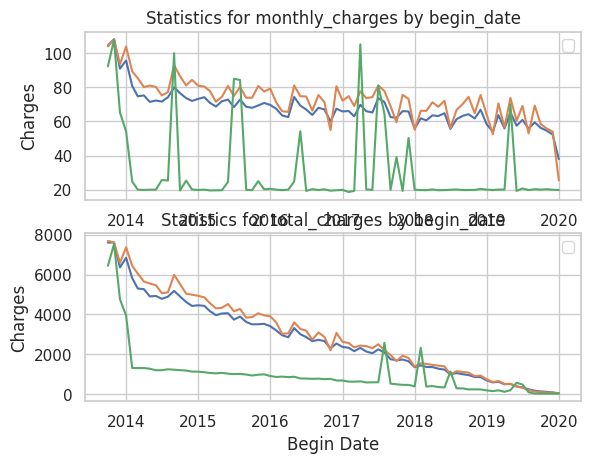

In [10]:
# Инициализация переменной для названия колонки
x = "begin_date"

# Список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# Удаление пустых значений для посчёта статистик
df.dropna(subset=charges_columns, how='any', inplace=True)

# Список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # Среднее значение, медиана и мода

# Группировка данных по дате начала и агрегация статистик для ежемесячных платежей
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# Удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()

# Переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# Аналогичная агрегация для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()

# Удаление верхнего уровня индекса колонок (после агрегации)
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# Создание графиков
fig, axs = plt.subplots(2, 1)


# Построение графика для monthly_charges
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
axs[0].set_title(f"Statistics for monthly_charges by {x}")
axs[0].set_xlabel('Begin Date')
axs[0].set_ylabel('Charges')
axs[0].legend()

# Построение графика для total_charges
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
axs[1].set_title(f"Statistics for total_charges by {x}")
axs[1].set_xlabel('Begin Date')
axs[1].set_ylabel('Charges')
axs[1].legend()

# Сохранение графиков
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

In [ ]:
### ЗАДАНИЕ 5

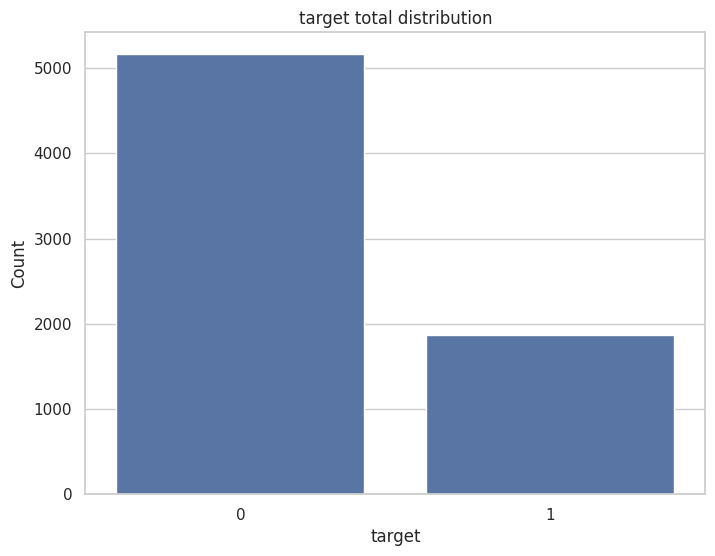

In [11]:
# Директория для сохранения картинок
ASSETS_DIR = "assets"
os.makedirs(ASSETS_DIR, exist_ok=True)

# Название колонки для агрегации
x = "target"

# Подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()
target_agg.columns = [x, 'count']

# Создание столбчатой диаграммы для визуализации распределения целевой переменной
plt.figure(figsize=(8, 6))
sns.barplot(data=target_agg, x='target', y='count')

# Установка заголовка графика
plt.title(f"{x} total distribution")
plt.xlabel(x)
plt.ylabel('Count')

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

In [ ]:
### ЗАДАНИЕ 6

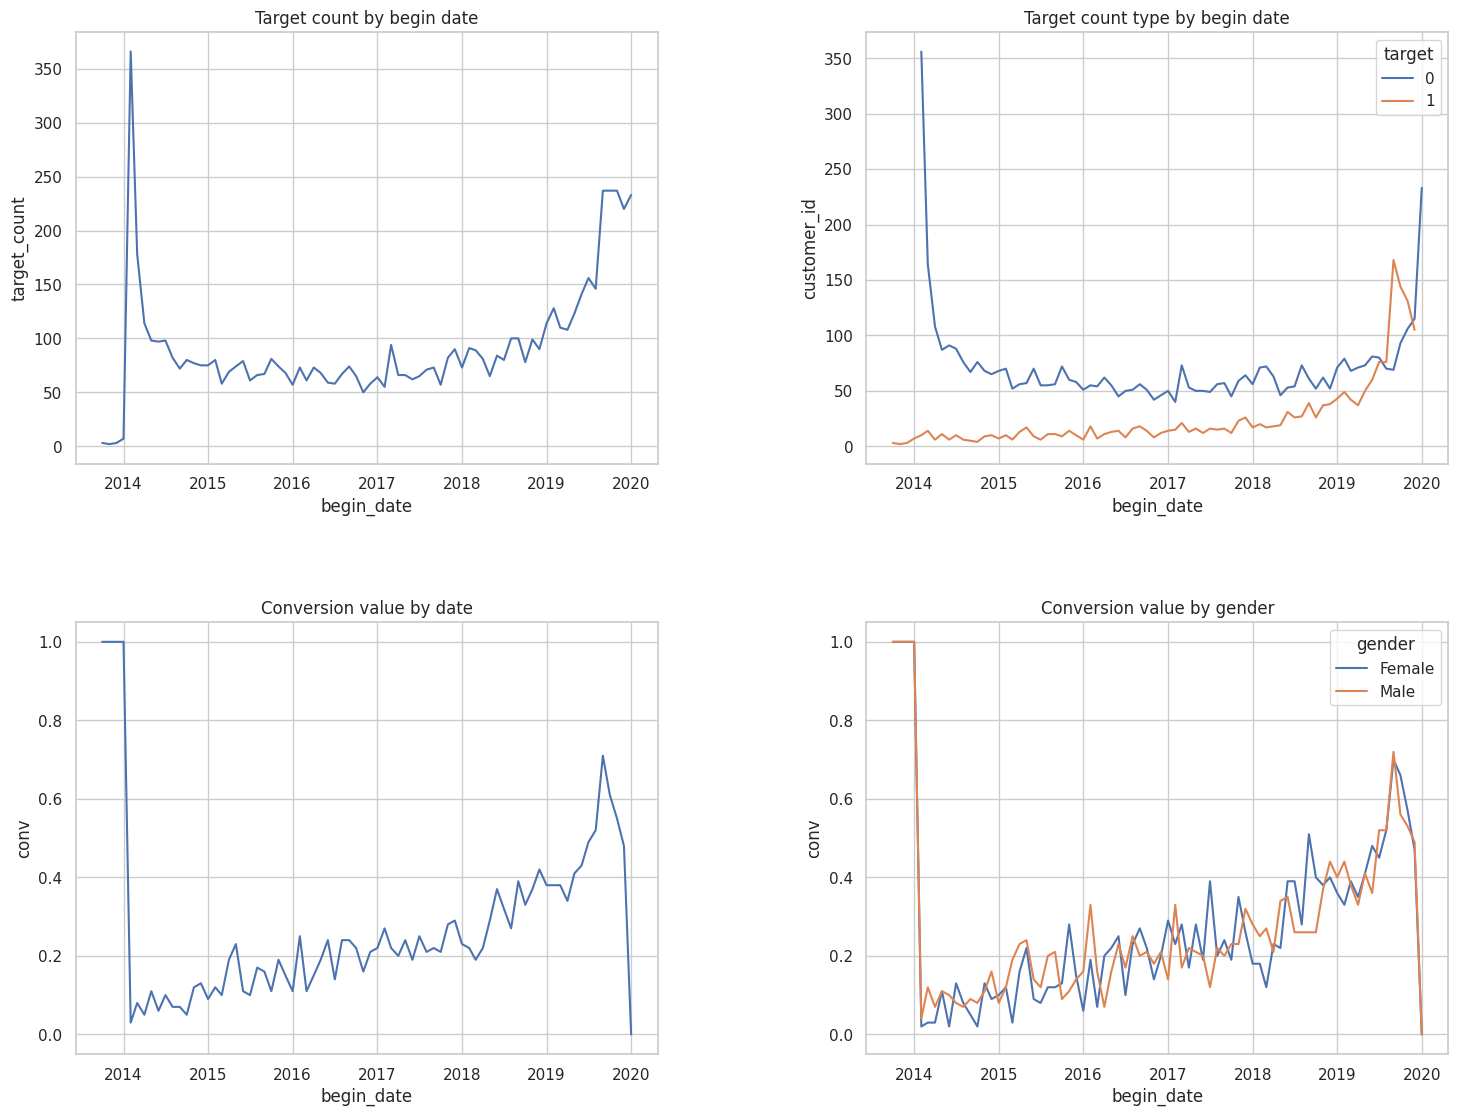

In [12]:
# Установка переменных для анализа
x = "begin_date"
target = "target"

# Установка статистики для агрегации
stat = ["count"]

# 1. Агрегация количества целей (1) по датам начала
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()  # Сумма 1 по каждой дате
target_agg_by_date.columns = [x, "target_count"]

# 2. Подсчёт количества клиентов для каждого значения цели (0 и 1) по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# 3. Расчёт конверсии (количество 1 на общий размер датасета)
conversion_agg = df[[x, target]].groupby([x])["target"].agg(["sum", "count"]).reset_index()
conversion_agg["conv"] = (conversion_agg["sum"] / conversion_agg["count"]).round(2)


# 4. Аналогичный расчёт конверсии по полу (подсчитываем долю 1 среди всех клиентов для каждого пола)
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

# 5. Инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# 6. Визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# 7. Визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# 8. Визуализация коэффициента конверсии по датам с использованием `conversion_agg_conv`
# Используем индекс как дату
sns.lineplot(data=conversion_agg, x=x, y='conv', ax=axs[1, 0])
axs[1, 0].set_title("Conversion value by date")

# 9. Визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# 10. Сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

# Показываем график
plt.show()

In [ ]:
### ЗАДАНИЕ 7

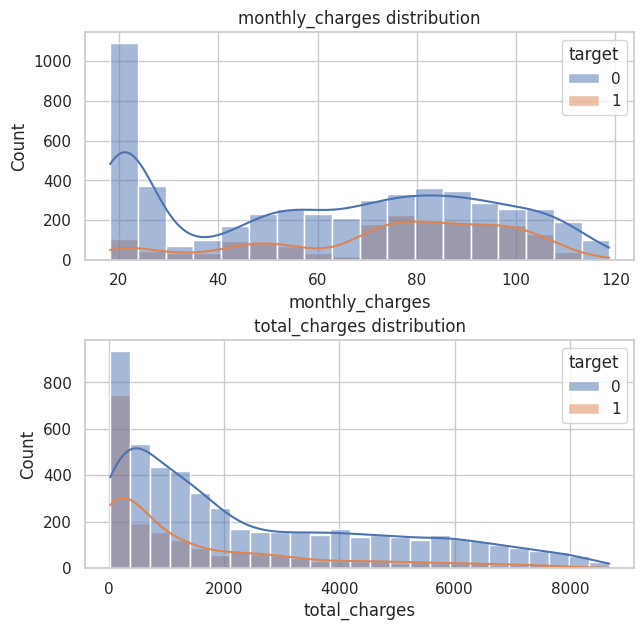

In [13]:
charges = ["monthly_charges", "total_charges"]
target = "target"

# Инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # Настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # Установка размера фигуры

# Визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
axs[0].set_title(f"{charges[0]} distribution")  # Установка заголовка для гистограммы

# Визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# Сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [ ]:
### ЗАДАНИЕ 8

In [15]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 